# Project Name

---

## Table of Contents <a name="toc"></a>

---

- 1.[**Data Source Information**](#datasource)
- 2.[**Setup**](#setup)
  - 2.1. [Environment Details for Reproducility](#env)
  - 2.2. [Importing the Data](#dataimport)
- 3.[**Data Preprocessing**](#datapre)


## 1. Data Source Information <a name="datasource"></a>

---


## 2. Setup <a name="setup"></a>

---


In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, AutoDateFormatter

from prophet import Prophet

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2.1. Environment Information for Reproducibility: <a name="env"></a>

### 2.2. Importing the Data: <a name="dataimport"></a>

In [2]:
# Set directories
current_wdir = os.getcwd()
data_folder_hourly = current_wdir + '/Data/Hourly_Load'
data_folder_gen = current_wdir + '/Data/Gen_by_Fuel'

## 3. Data Preprocessing <a name="datapre"></a>

---

In [3]:
file_path_load = [f'{data_folder_hourly}/{file}' for file in os.listdir(data_folder_hourly) if '.csv' in file]
file_path_load = sorted(file_path_load)

file_path_gen = [f'{data_folder_gen}/{file}' for file in os.listdir(data_folder_gen) if '.csv' in file]
file_path_gen = sorted(file_path_gen)

# pd.read_csv can unzip as it goes with compression argument.
load_df = pd.concat([pd.read_csv(file, compression = 'gzip') for file in file_path_load], join = 'outer', ignore_index = False, axis = 0)
gen_df = pd.concat([pd.read_csv(file, compression = 'gzip') for file in file_path_gen], join = 'outer', ignore_index = False, axis = 0)

In [4]:
display(load_df)
display(load_df.dtypes)

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,BC,BC,2358.000,True
1,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,CNCT,AE,855.000,True
2,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,CNCT,DPL,1150.000,True
3,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,GPU,JC,1632.000,True
4,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,GPU,ME,929.000,True
...,...,...,...,...,...,...,...,...
62605,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,RECO,RECO,131.877,False
62606,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,PEP,SMECO,355.931,False
62607,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,PL,UGI,101.478,True
62608,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,AE,VMEU,70.051,False


datetime_beginning_utc     object
datetime_beginning_ept     object
nerc_region                object
mkt_region                 object
zone                       object
load_area                  object
mw                        float64
is_verified                  bool
dtype: object

In [5]:
display(gen_df)
display(gen_df.dtypes)

,datetime_beginning_utc,datetime_beginning_ept,fuel_type,mw,fuel_percentage_of_total,is_renewable
0,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Coal,34820,0.41,False
1,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Gas,11169,0.13,False
2,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Hydro,699,0.01,True
3,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Multiple Fuels,266,0.00,False
4,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Nuclear,34269,0.41,False
...,...,...,...,...,...,...
21095,1/1/2024 5:00:00 AM,1/1/2024 12:00:00 AM,Oil,221,0.00,False
21096,1/1/2024 5:00:00 AM,1/1/2024 12:00:00 AM,Other Renewables,690,0.01,True
21097,1/1/2024 5:00:00 AM,1/1/2024 12:00:00 AM,Solar,12,0.00,True
21098,1/1/2024 5:00:00 AM,1/1/2024 12:00:00 AM,Storage,0,0.00,False


datetime_beginning_utc       object
datetime_beginning_ept       object
fuel_type                    object
mw                            int64
fuel_percentage_of_total    float64
is_renewable                   bool
dtype: object

In [6]:
date_cols = ['datetime_beginning_utc', 'datetime_beginning_ept']
load_df[date_cols] = load_df[date_cols].apply(pd.to_datetime, format = '%m/%d/%Y %I:%M:%S %p', utc = False)
gen_df[date_cols] = gen_df[date_cols].apply(pd.to_datetime, format = '%m/%d/%Y %I:%M:%S %p', utc = False)

In [7]:
sorted(load_df['zone'].unique())

['AE',
 'AEP',
 'AP',
 'ATSI',
 'BC',
 'CE',
 'CNCT',
 'DAY',
 'DEOK',
 'DOM',
 'DPL',
 'DUQ',
 'EKPC',
 'GPU',
 'JC',
 'ME',
 'OVEC',
 'PE',
 'PEP',
 'PL',
 'PN',
 'PS',
 'RECO',
 'RTO']

In [8]:
load_zone_df = load_df[['datetime_beginning_ept', 'zone', 'mw']].groupby(['datetime_beginning_ept', 'zone'], as_index = False).sum()

In [9]:

load_total_df = load_df[['datetime_beginning_ept', 'mw']].groupby(['datetime_beginning_ept'], as_index = False).sum()

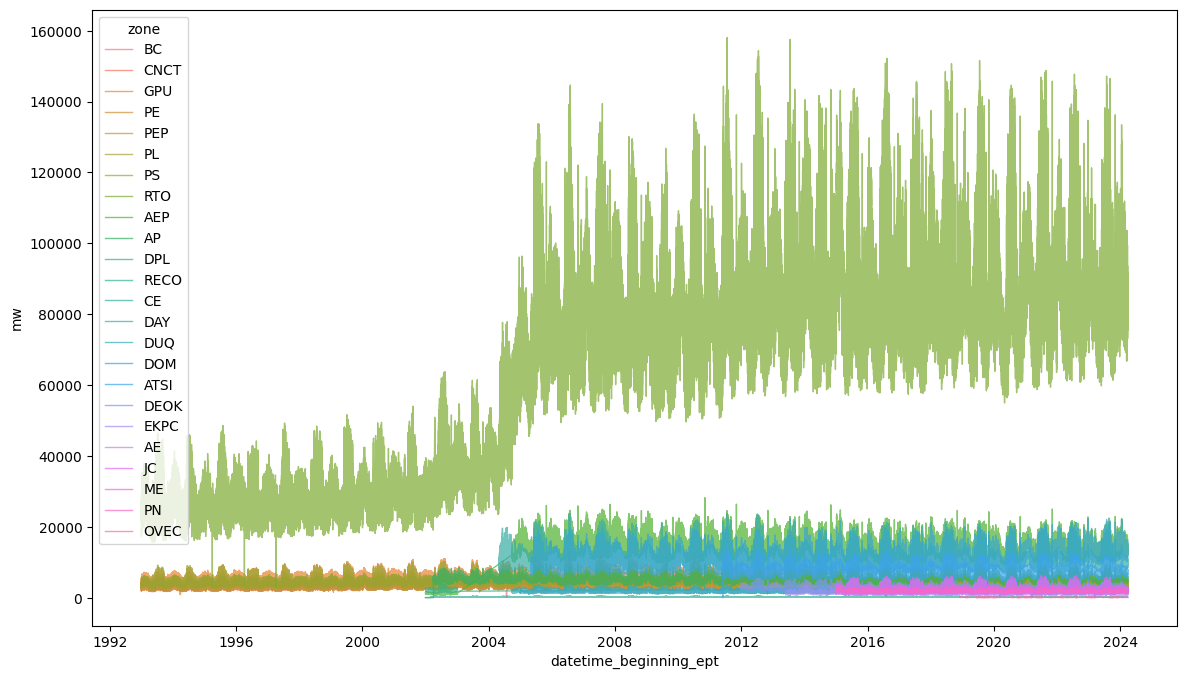

In [10]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(load_zone_df, x = 'datetime_beginning_ept', y = 'mw',  hue = 'zone', alpha = 0.7, lw = 1)

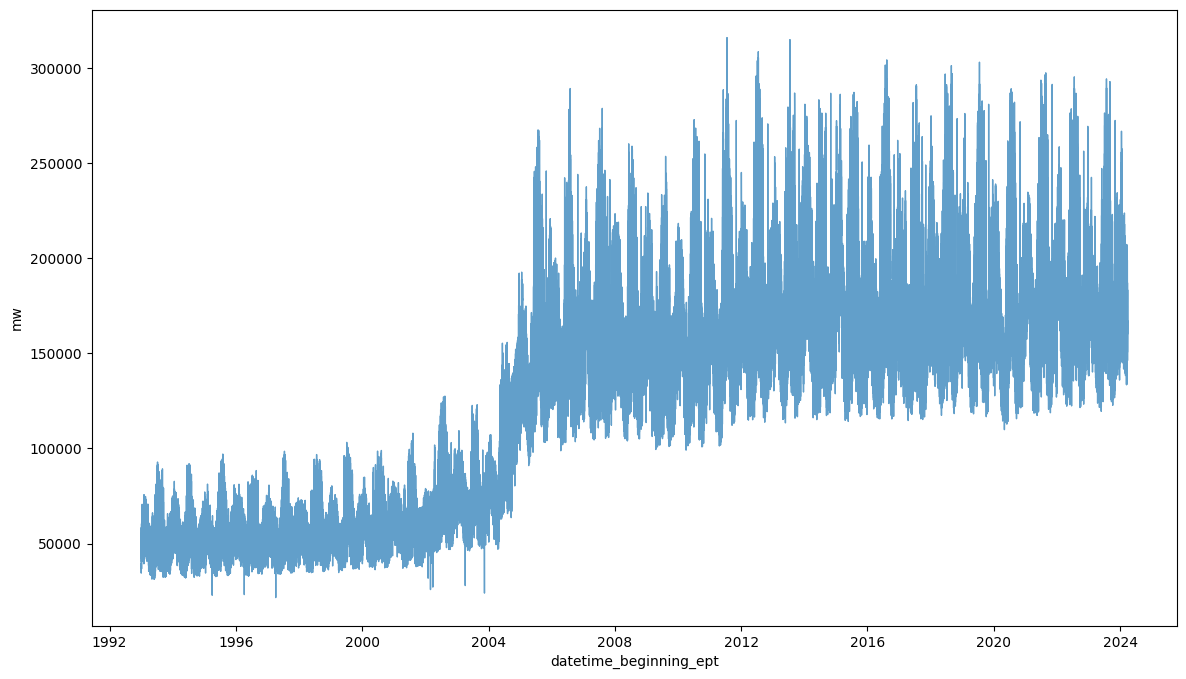

In [11]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(load_total_df, 
                  x = 'datetime_beginning_ept', 
                  y = 'mw',  
                  alpha = 0.7, lw = 1)

In [12]:
load_total_df

,datetime_beginning_ept,mw
0,1993-01-01 00:00:00,39270.000
1,1993-01-01 01:00:00,37032.000
2,1993-01-01 02:00:00,35330.000
3,1993-01-01 03:00:00,34438.000
4,1993-01-01 04:00:00,34446.000
...,...,...
273779,2024-03-27 19:00:00,178214.888
273780,2024-03-27 20:00:00,180069.762
273781,2024-03-27 21:00:00,175984.754
273782,2024-03-27 22:00:00,168237.264


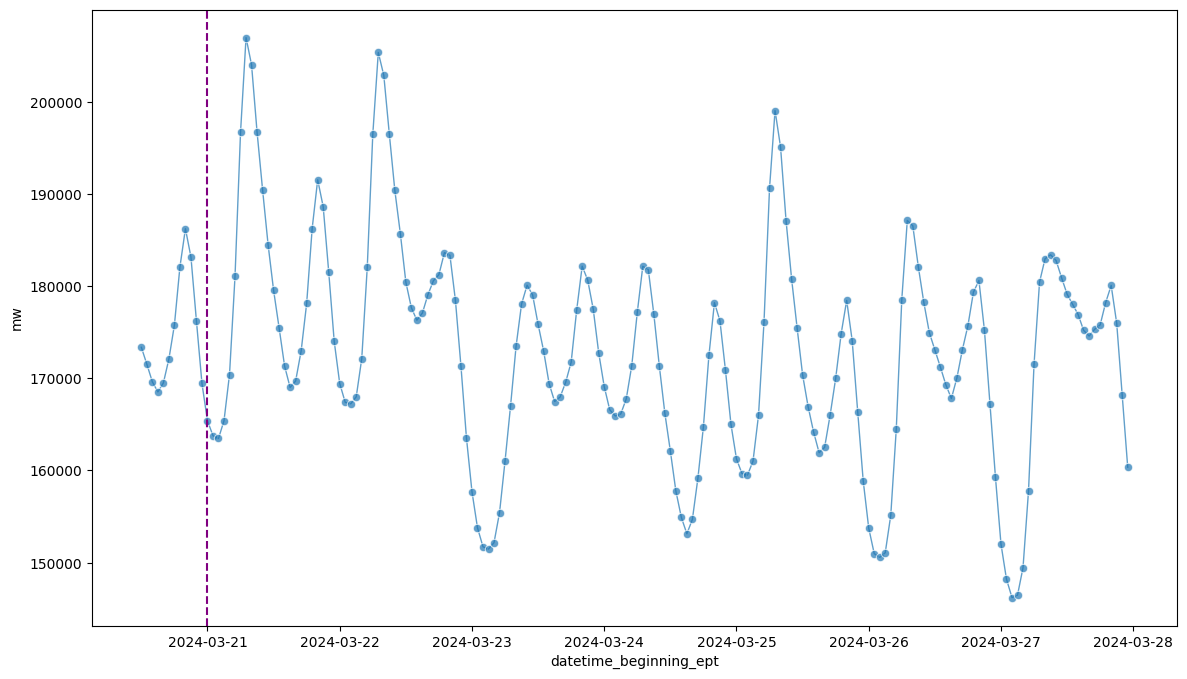

In [13]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(load_total_df.loc[load_total_df['datetime_beginning_ept'] > '3/20/2024 11:00:00'], 
                  x = 'datetime_beginning_ept', 
                  y = 'mw',  
                  alpha = 0.7, lw = 1, marker = 'o')

plt.axvline(pd.to_datetime('2024-03-21 00:00:00'), color = 'purple', ls = '--')

In [14]:
gen_fuel_df = gen_df[['datetime_beginning_ept', 'fuel_type', 'mw']].groupby(['datetime_beginning_ept', 'fuel_type'], as_index = False).sum()

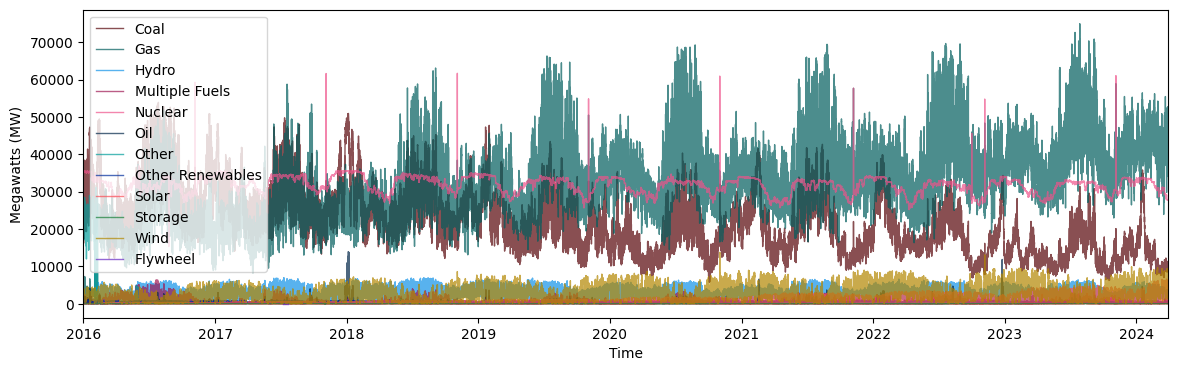

In [15]:
palette = ['#570408', '#005d5d', '#1192e8', '#9f1853', '#ee538b', '#012749', '#009d9a', '#002d9c', '#fa4d56', '#198038', '#b28600', '#6929c4']

ax, fig = plt.subplots(figsize = (14, 4))
ax = sns.lineplot(gen_fuel_df, x = 'datetime_beginning_ept', y = 'mw',  hue = 'fuel_type', alpha = 0.7, lw = 1, palette = sns.color_palette(palette, 12))
ax.margins(x = 0)
ax.set_xlabel('Time')
ax.set_ylabel('Megawatts (MW)')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles = handles, labels = labels)
plt.legend(loc = 'upper left')
plt.show()

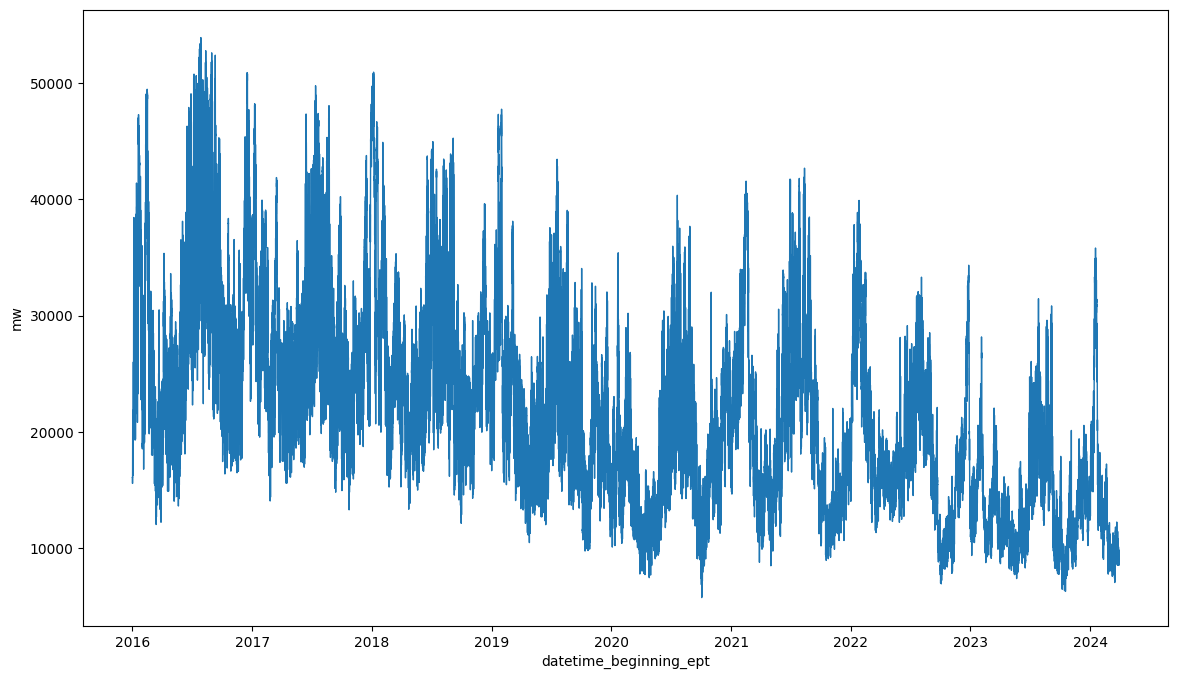

In [16]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Coal'], x = 'datetime_beginning_ept', y = 'mw', lw = 1)

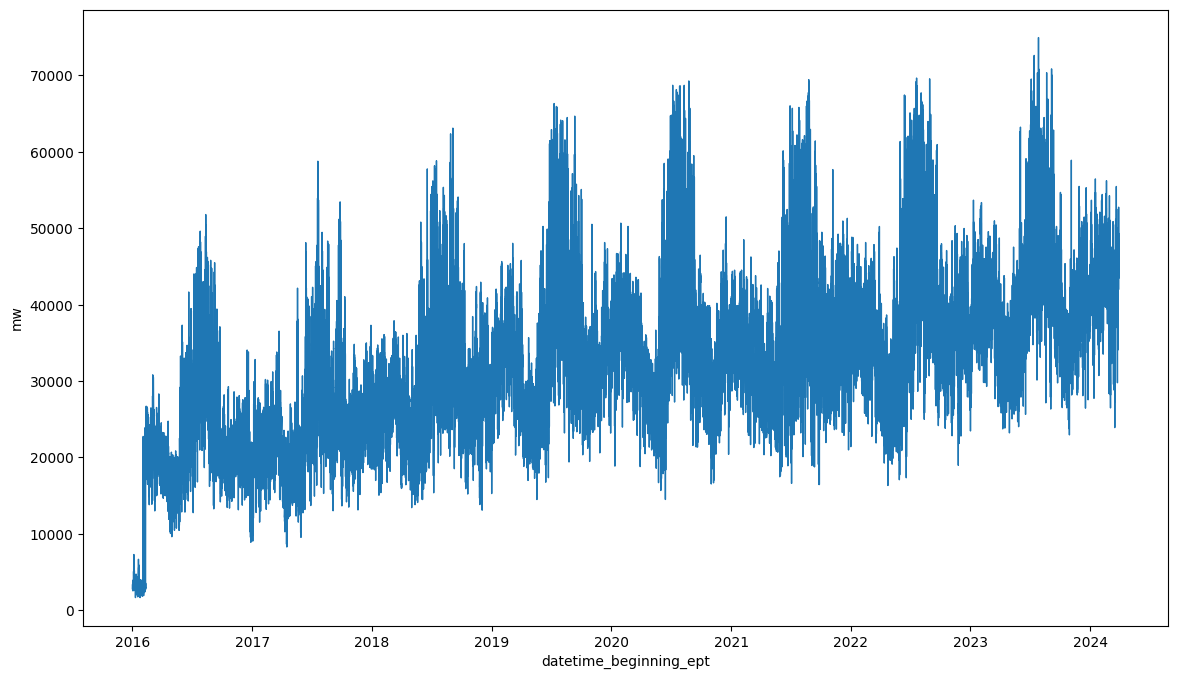

In [17]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Gas'], x = 'datetime_beginning_ept', y = 'mw', lw = 1)

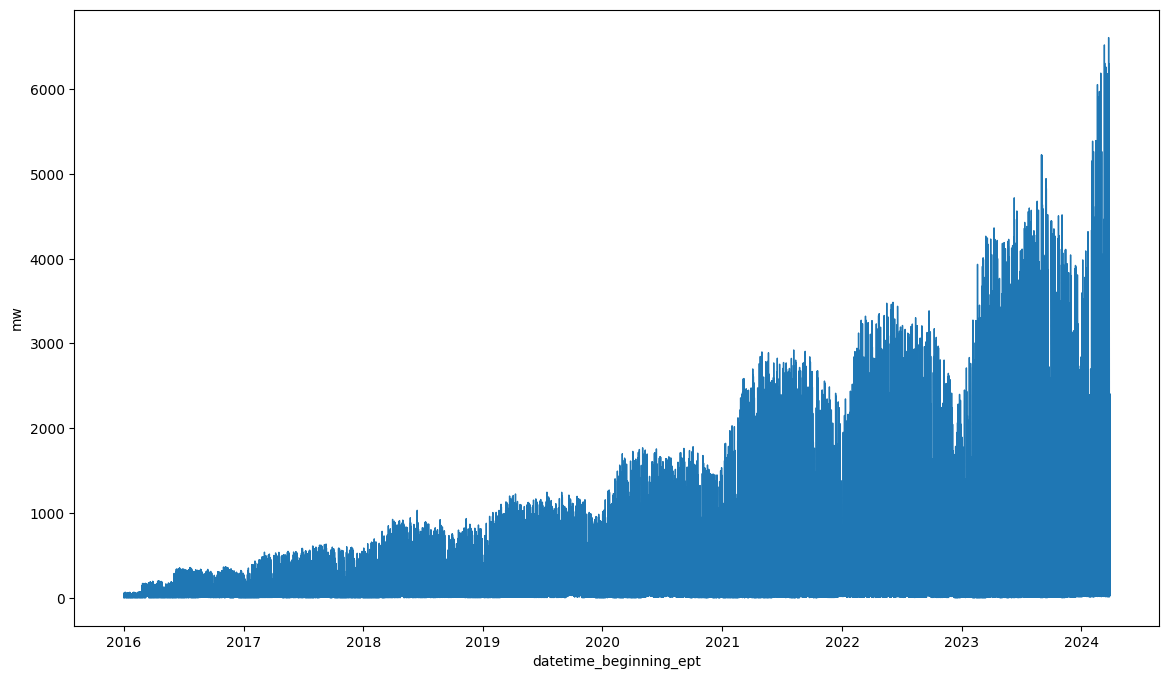

In [18]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Solar'], x = 'datetime_beginning_ept', y = 'mw', lw = 1)

In [19]:
print(gen_df['datetime_beginning_ept'].min())
print(gen_df['datetime_beginning_ept'].max())
print(load_df['datetime_beginning_ept'].min())
print(load_df['datetime_beginning_ept'].max())

2016-01-01 00:00:00
2024-03-28 23:00:00
1993-01-01 00:00:00
2024-03-27 23:00:00


## Seeking the Prophet

---

Just temporarily building a model from Meta's Prophet to use in a few visualizations.

Feelin' cute, might delete later.

In [20]:
df = pd.DataFrame({'ds' : gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Gas']['datetime_beginning_ept'],
                   'y' : gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Gas']['mw']})
m = Prophet()
m.fit(df)

15:26:56 - cmdstanpy - INFO - Chain [1] start processing
15:27:22 - cmdstanpy - INFO - Chain [1] done processing


,ds
72811,2026-03-24 23:00:00
72812,2026-03-25 23:00:00
72813,2026-03-26 23:00:00
72814,2026-03-27 23:00:00
72815,2026-03-28 23:00:00


,ds,yhat,yhat_lower,yhat_upper
72811,2026-03-24 23:00:00,43858.316800,-4252.070464,95679.410551
72812,2026-03-25 23:00:00,43882.657178,-3028.297206,96126.482771
72813,2026-03-26 23:00:00,43271.392986,-4071.257931,96505.564821
72814,2026-03-27 23:00:00,41712.455949,-6380.943517,94709.455600
72815,2026-03-28 23:00:00,38005.122236,-9355.052150,90346.830715


/opt/homebrew/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/homebrew/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


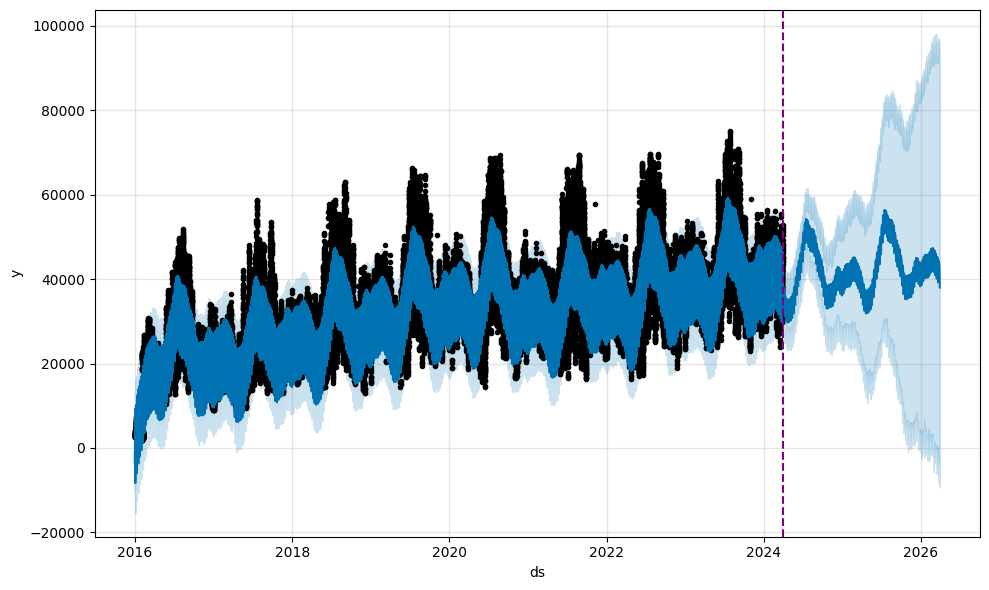

In [21]:
future = m.make_future_dataframe(periods=365*2)
display(future.tail())
forecast = m.predict(future)
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
fig1 = m.plot(forecast)
ax = fig1.gca()
plt.axvline(max(df['ds']), color = 'purple', ls = '--')

In [22]:
# Sourced from the prophet repository and repurposed to include:
# - Delineate observed data and forecasted data (dashed line)
# - Separate observed data and forecasted data for different visuals
# - Color changes
# - Zoom into the last few years to better visualize forecast (currently hardcoded)

def prophetplot(m, fcst, ax=None, uncertainty=True, plot_cap=True, xlabel='Time', ylabel='Megawatts (MW)',
    figsize=(10, 6), include_legend=False):
    """Plot the Prophet forecast.

    Parameters
    ----------
    m: Prophet model.
    fcst: pd.DataFrame output of m.predict.
    ax: Optional matplotlib axes on which to plot.
    uncertainty: Optional boolean to plot uncertainty intervals, which will
        only be done if m.uncertainty_samples > 0.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    xlabel: Optional label name on X-axis
    ylabel: Optional label name on Y-axis
    figsize: Optional tuple width, height in inches.
    include_legend: Optional boolean to add legend to the plot.
    Returns
    -------
    A matplotlib figure.
    """
    user_provided_ax = False if ax is None else True
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    fcst_t = fcst['ds']#.dt.to_pydatetime()

    # Initialize the observation and forecast data variables
    # Finds and separates the two sets by using the max date in (observed) input data.
    obs_t = fcst_t.loc[fcst_t < max(df['ds'])]
    obs_yhat = fcst['yhat'].iloc[ : fcst['ds'].loc[fcst['ds'] <= max(df['ds'])].index[-1]]
    obs_lower = fcst['yhat_lower'].iloc[ : fcst['ds'].loc[fcst['ds'] <= max(df['ds'])].index[-1]]
    obs_upper = fcst['yhat_upper'].iloc[ : fcst['ds'].loc[fcst['ds'] <= max(df['ds'])].index[-1]]
    fc_t = fcst_t.loc[fcst_t >= max(df['ds'])]
    fc_yhat = fcst['yhat'].iloc[fcst['ds'].loc[fcst['ds'] >= max(df['ds'])].index[0]:]
    fc_lower = fcst['yhat_lower'].iloc[fcst['ds'].loc[fcst['ds'] >= max(df['ds'])].index[0]:]
    fc_upper = fcst['yhat_upper'].iloc[fcst['ds'].loc[fcst['ds'] >= max(df['ds'])].index[0]:]

    ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], '.', c = '#012749', markersize = 1, alpha = 0.9,
            label='Observed data points')
    ax.plot(obs_t, obs_yhat, ls='-', c='#005d5d', label='Forecast', lw = 0.75, alpha = 0.9)
    ax.plot(fc_t, fc_yhat, ls='-', c='#382238', label='Predict', lw = 0.75, alpha = 1)
    if 'cap' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['cap'], ls='--', c='k', label='Maximum capacity')
    if m.logistic_floor and 'floor' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['floor'], ls='--', c='k', label='Minimum capacity')
    if uncertainty and m.uncertainty_samples:
        ax.fill_between(obs_t, obs_lower, obs_upper,
                        color='#009d9a', alpha=0.4, label='Uncertainty interval')
        ax.fill_between(fc_t, fc_lower, fc_upper,
                        color='#753f75', alpha=0.4, label='Uncertainty interval')
    # Specify formatting to workaround matplotlib issue #12925
    locator = AutoDateLocator(interval_multiples=False)
    formatter = AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(True, which='major', c='gray', ls='-', lw=0.75, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Zoom in x-axis closer to prediction.
    ax.set_xlim(pd.to_datetime(['2020-01-01 00:00:00', '2026-01-01 00:00:00']))
    ax.set_ylim(0, 90000)

    # Prediction divider line.
    plt.axvline(max(df['ds']), color = 'black', ls = '--', lw = 1.2)

    # Linear trend line to calculate yearly increase.
    obs_poly_fn = np.poly1d(np.polyfit(range(len(obs_t)), obs_yhat, 1))
    plt.plot(obs_t, obs_poly_fn(range(len(obs_t))), c = '#913529')

    fc_poly_fn = np.poly1d(np.polyfit(range(len(fc_t)), fc_yhat, 1))
    plt.plot(fc_t, fc_poly_fn(range(len(fc_t))), c = '#252f9c')

    if include_legend:
        ax.legend()
        plt.legend(loc = 'upper left')
    if not user_provided_ax:
        fig.tight_layout()
    return fig

/var/folders/m8/939h_p3x6fq4_c0w_pfktz840000gn/T/ipykernel_33582/2529771525.py:46: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], '.', c = '#012749', markersize = 1, alpha = 0.9,


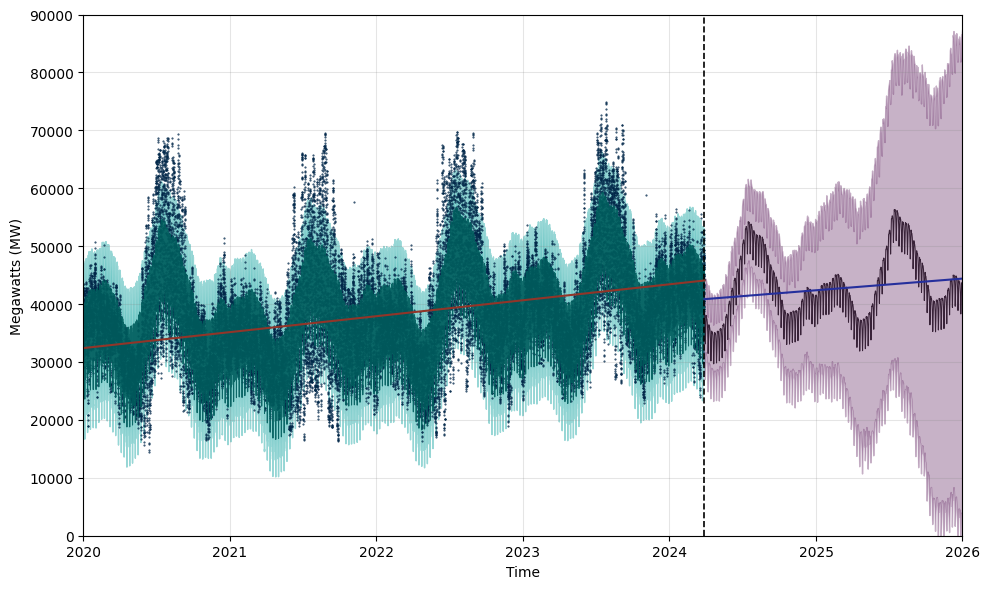

In [23]:
prophetplot(m, forecast)
plt.show()